# TEST POTENTIAL FUNCTIONS SFO
### The object of this section of script is to create the functions that handle the population.
### The idea is to take the population make random changes, create the fluxes matrix ( now this matrix is going to be in a subset of possible matrices in some ensemble that I do not know how to describe.) Now I renormalize the fluxes matrix.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import time
from shapely.geometry import box
from shapely.ops import unary_union
import socket
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8


mother_path: /home/alberto/LPSim/traffic_phase_transition/scripts


/home/alberto/LPSim/traffic_phase_transition/scripts/PreProcessing/Potential.py:395: SyntaxWarning: invalid escape sequence '\d'
  '''


## Directories of interest

In [2]:
import gzip

cartodir = os.path.join(TRAFFIC_DIR,'data','carto','BOS')
dirgrid = os.path.join(cartodir,'grid')
potentialdir = os.path.join(cartodir,'potential')

#with open(os.path.join(cartodir,'d0s.json'),'r') as f:
#    json.load(f)

if not os.path.exists(os.path.join(cartodir,'d0s.json')):
    d = {'d0':d0,'filteredd0':list(d0filtered.astype(float))}
    with gzip.open(os.path.join(cartodir,'d0s.json'), "wt") as json_file:
        json.dump(d, json_file)
else:
    with gzip.open(os.path.join(cartodir,'d0s.json'), "rt") as json_file:
        data = json.load(json_file)


# FUNCTIONS OF INTEREST

In [3]:
## Play With Population
def ReassignPopulationRandomly(population, m0, m1, N):
    '''
        This function reassign population according to ModifyPop principles
    '''
    indices = np.where(population > 0)[0]  # Step 1

    for _ in range(N):
        index = np.random.choice(indices)  # Step 2
        rand_value = np.random.exponential(m0)  # Step 3
        exp_value = np.exp(-population[index] / m1)  # Exponential value of vector[index] / b
        if rand_value > exp_value:  # Step 4
            population[index] = 0
            index1 = np.random.choice(indices)
            population[index1] += rand_value  # Step 5
    return population

def ModifyPop(population,A,m0,m1):
    '''
        The idea is to redistribute the population in such a way that we favor the big population. Where big is given by the m1 weight rather then m0
        If m1 is bigger then m0 then the big centers have low probability of being redistributed.
        m1 big -> Toward monocentrism
        m1 -> small Toward polycentrism
    '''
    global iterations
    if isinstance(population,np.ndarray):
        pass
    else:
        population = np.array(population)
    population = ReassignPopulationRandomly(population,m0,m1,iterations)    
    return population

# Stop Playing with Population

##### PLOTTING SESSION #####
def PlotDistributionFit(ObservationVector,label,Name2Function,x_label = 'Population',y_label = 'Counts',x_scale = 'log',y_scale = 'log'):
    '''
        Input:
            ObservationVector: np.array
            label: str (powerlaw,exponential,linear)
            Name2Function: dict [Is the one coming from FittingProcedures.py]
            x_label: str (default = 'Population')
            y_label: str (default = 'Counts')
        Description:
            This function takes a distribution vector and plots it along with the exponential fit.
        
    '''
    if label == 'exponential':
        b = (bins[0] - bins[5])/np.log(n[5]/n[0])
        A = np.exp(bins[0]/b)*n[0]    
        print('A:',A)
        print('b:',b)
        initial_guess = (n[0],b)
        maxfev = 10000
    else:
        initial_guess = (1,1)
        maxfev = 10000
    if not isinstance(ObservationVector,np.ndarray):
        ObservationVector = np.array(ObservationVector)
    n,bins = np.histogram(ObservationVector,bins = 100)
    fit = Fitting(bins[:-1],n,label = label,initial_guess=initial_guess,maxfev = maxfev)
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.scatter(bins[:-1],n)
    plt.plot(bins[:-1],Name2Function[label](bins[:-1],fit[0][0],fit[0][1]),color = 'red')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} fit'.format(label))
    ax.set_yscale(x_scale)
    ax.set_xscale(y_scale)
    plt.show()

In [4]:
# Get directories and parameters of interest
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))


Initialize Grid: 0.02
ALREADY COMPUTED


In [ ]:
# TODO: Suppose you have a population distribution that is an exponential with fitting parameter m0. I want to redistribute the mass in such a way
# that I take favor the big population, then I fix 
n,bins = np.histogram(grid['population'].to_numpy())

ResultFit = Fitting(bins[:-1],n,label = 'exponential',initial_guess = (6000,0.3),maxfev = 10000)

A, m0 = ResultFit[0],ResultFit[1]
iterations = len(grid['population'].to_numpy())
amplifications = np.arange(0.1,10,100)
for amp in amplifications:
    ModifyPop(grid['population'],A,m0,amp*m0)


# CHECK MASS, FLUX DISTANCE INTERPLAY

In [ ]:
pop = []
flux = []
distance = []
count = 0
NetFlux = Tij[Tij['number_people'] > 0]
print('Fraction fluxes different from 0: ',len(NetFlux)/len(Tij))    
for gdf in NetFlux.groupby('origin'):
    for _,row in gdf[1].iterrows():
        flux.append(row['number_people'])
        dij = df_distance[df_distance['i'].values  == gdf[1]['origin'].values[0]]
        dij =  dij[dij['j'].values == row['destination']]['distance']
        if len(dij) > 1:
            break
        distance.append(dij.values[0])
        pop.append(grid['population'].loc[gdf[1]['origin'].iloc[0]])
        if count == 0:
            print('flux: ',flux)
            print('distance: ',distance)
            print('pop: ',pop)
        count += 1



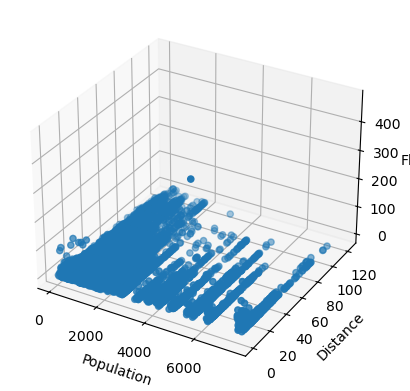

shape x_centers: (20,) shape y_centers: (20,) shape z_centers: (20,)
shape X: (20, 20, 20) shape Y: (20, 20, 20) shape Z: (20, 20, 20)


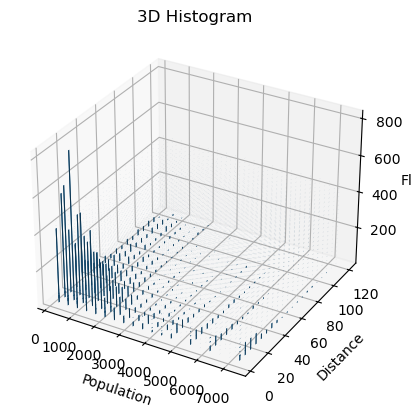

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(pop, distance, flux[:-1])

# Set labels and title
ax.set_xlabel('Population')
ax.set_ylabel('Distance')
ax.set_zlabel('Flux')
ax.set_title('')
plt.show()

# 3D HISTOGRAM
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Define the number of bins
nbins = 20
# Create the 3D histogram
hist, edges = np.histogramdd((pop, distance, flux[:-1]), bins=(nbins, nbins, nbins))
# Get the centers of the bins
x_centers = (edges[0][:-1] + edges[0][1:]) / 2
y_centers = (edges[1][:-1] + edges[1][1:]) / 2
z_centers = (edges[2][:-1] + edges[2][1:]) / 2
X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')
print('shape x_centers:',x_centers.shape,'shape y_centers:',y_centers.shape,'shape z_centers:',z_centers.shape)
print('shape X:',X.shape,'shape Y:',Y.shape,'shape Z:',Z.shape)
# Plot the histogram
ax.bar3d(X.ravel(), Y.ravel(), Z.ravel(), 1, 1, hist.flatten())
# Set labels and title
ax.set_xlabel('Population')
ax.set_ylabel('Distance')
ax.set_zlabel('Flux')
ax.set_title('3D Histogram')
plt.show()

# 3D HISTOGRAM


# FIT SECTION

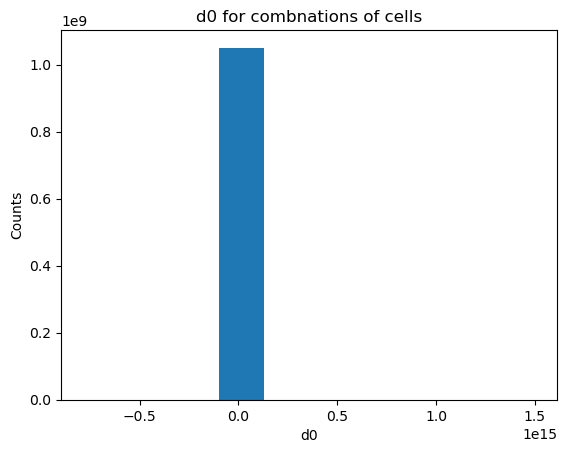

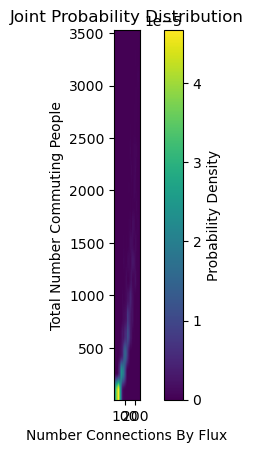

"\n    Vnpeople, Vorigins, Vdestinations = SubsampleFluxesByPop(Vnpeople, Vorigins, Vdestinations)\n    cell_x = Vorigins[0]\n    print('First Cell(x) considered: ',cell_x)\n    print('Total number of Couples whose Interaction is more then 0: ',len(Vnpeople))\n    IndicesXFlux,VnpeopleX, VoriginsX, VdestinationsX = SubsampleByCellFluxOrigin(Vnpeople, Vorigins, Vdestinations,cell_x)\n    print('Vector number people whose origin is in {} : '.format(cell_x),VnpeopleX)\n    print('Number of destinations: ',len(VnpeopleX))\n    t1 = time.time()\n    print('Time to compute subset of destination for x: ',t1-t0)\n    timeX = t1-t0\n    t0 = time.time()\n    cell_i = VdestinationsX[0]\n    IndicesXFluxi,VnpeopleXi, VoriginsXi, VdestinationsXi = SubsampleByCellFluxDestination(VnpeopleX, VoriginsX, VdestinationsX,cell_i)\n    print('Vector number people i: ',VnpeopleXi)\n    print('Number of destinations: ',len(VnpeopleXi))\n    t1 = time.time()\n    print('Time to compute subset of destination f

In [4]:
if FoundDistMat:
    distance_matrix = DistanceDf2Matrix(df_distance) # 1.2 s with 3470 grids
    VgridIdx,VgridPopulation = Grid2Arrays(grid) # 0.0003 with 3470
    Vnpeople,Vorigins,Vdestinations = T2Arrays(Tij) # 0.07
    Vnpeople, Vorigins, Vdestinations = SubsampleFluxesByPop(Vnpeople, Vorigins, Vdestinations)    
    d0,d0s = d0PotentialFitOptimized(Vnpeople, Vorigins, Vdestinations, VgridIdx,VgridPopulation, distance_matrix)    #time spent to compute max size:  272.7686324119568
#    max_size:  1050954335
    plt.hist(d0s)
    plt.xlabel('d0')
    plt.ylabel('Counts')
    plt.title('d0 for combnations of cells')
    plt.show()

#    d0,k = GetkPotential(grid,df_distance,Tij,d0,dir_geometries)
    GetCommunicationLevelsAmongGrids(Tij)
'''
    Vnpeople, Vorigins, Vdestinations = SubsampleFluxesByPop(Vnpeople, Vorigins, Vdestinations)
    cell_x = Vorigins[0]
    print('First Cell(x) considered: ',cell_x)
    print('Total number of Couples whose Interaction is more then 0: ',len(Vnpeople))
    IndicesXFlux,VnpeopleX, VoriginsX, VdestinationsX = SubsampleByCellFluxOrigin(Vnpeople, Vorigins, Vdestinations,cell_x)
    print('Vector number people whose origin is in {} : '.format(cell_x),VnpeopleX)
    print('Number of destinations: ',len(VnpeopleX))
    t1 = time.time()
    print('Time to compute subset of destination for x: ',t1-t0)
    timeX = t1-t0
    t0 = time.time()
    cell_i = VdestinationsX[0]
    IndicesXFluxi,VnpeopleXi, VoriginsXi, VdestinationsXi = SubsampleByCellFluxDestination(VnpeopleX, VoriginsX, VdestinationsX,cell_i)
    print('Vector number people i: ',VnpeopleXi)
    print('Number of destinations: ',len(VnpeopleXi))
    t1 = time.time()
    print('Time to compute subset of destination for i: ',t1-t0)
    timeXI = t1-t0
    print('Estimated time simulation: ',(len(Vnpeople)*2*(timeX + timeXI)/3600)**2,' h')
#    max_size = ComputeMaxSized0(Vnpeople, Vorigins, Vdestinations)    
#    print('number of computations: ',max_size)

'''

min d0s:  0.0  max:  1499706200000000.0


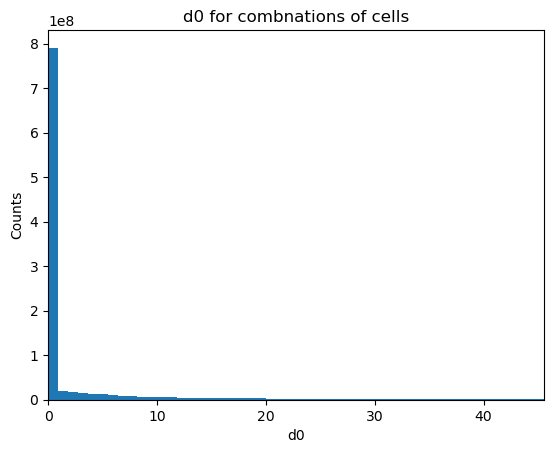

In [23]:
print('min d0s: ',np.min(np.abs(d0s)),' max: ',np.max(d0s))

def filter_within_percentage(arr, lower_percentile, upper_percentile):
    # Calculate the lower and upper percentile values
    lower_val = np.percentile(arr, lower_percentile)
    upper_val = np.percentile(arr, upper_percentile)
    
    # Filter values within the specified percentile range
    filtered_values = arr[(arr >= lower_val) & (arr <= upper_val)]
    
    return filtered_values
#d0filtered = filter_within_percentage(np.abs(d0s),0,95)
plt.hist(d0filtered,bins=50)
plt.xlim(np.min(d0filtered),np.max(d0filtered))
plt.xlabel('d0')
plt.ylabel('Counts')
plt.title('d0 for combinations of cells')
plt.show()


In [ ]:
distance_matrix = DistanceDf2Matrix(df_distance) # 1.2 s with 3470 grids
VgridIdx,VgridPopulation = Grid2Arrays(grid) # 0.0003 with 3470
Vnpeople,Vorigins,Vdestinations = T2Arrays(Tij) # 0.07
Vnpeople, Vorigins, Vdestinations = SubsampleFluxesByPop(Vnpeople, Vorigins, Vdestinations)
d0 = data['d0']
EstimateFluxesScaled,Fluxes = GetEstimationFluxesVector(Vnpeople, Vorigins, Vdestinations, VgridIdx, VgridPopulation, distance_matrix,d0)
d0,k,q = GetkPotential(EstimateFluxesScaled,Fluxes,d0,potentialdir)
with open(os.path.join(potentialdir,'FitFluxesParameters.json'),'w') as f:
    json.dump({'d0':float(d0),'k':k[0],'q': k[1]},f)

nFlux,binsFlux = np.histogram(Fluxes,bins = 100)
nEsteem, binsEsteem = np.histogram(EstimateFluxesScaled,bins = 100)
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(binsFlux[:-1],nFlux)
ax.plot(binsEsteem[:-1],nEsteem)
ax.set_xlabel('Fluxes')
ax.set_ylabel('Distribution')
ax.set_title('Comparison distribution Measured/Gravity Fluxes')
plt.show()

In [9]:
with open(os.path.join(potentialdir,'FitFluxesParameters.json'),'w') as f:
    json.dump({'d0':float(d0),'k':k[0],'q': k[1]},f)


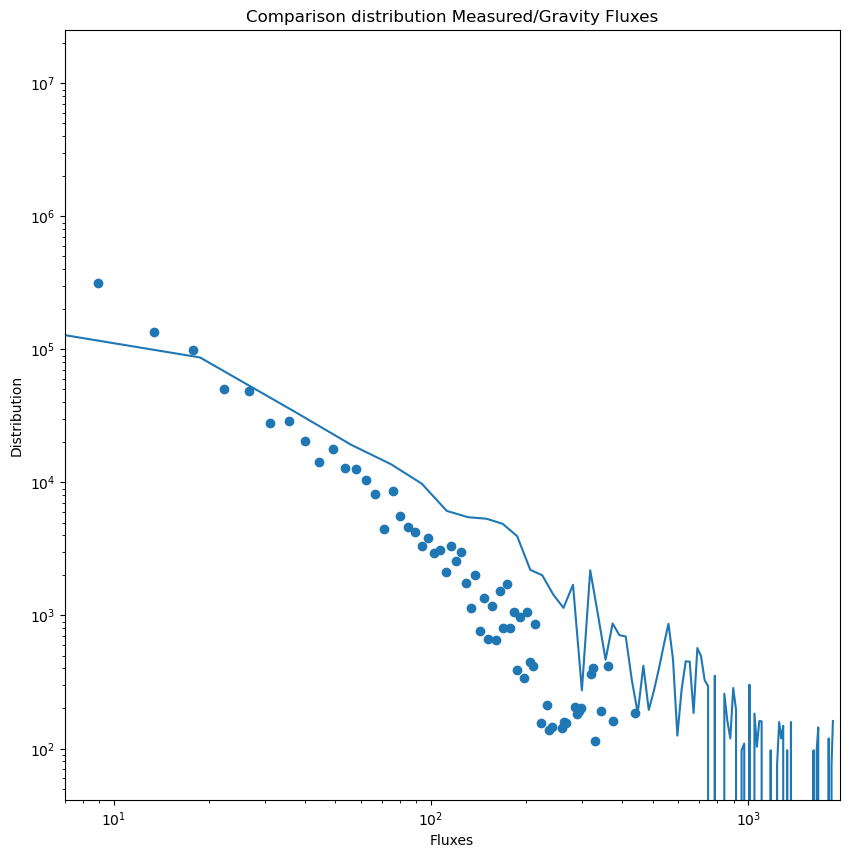

In [36]:

#k,error = Fitting(np.array(EstimateFluxesScaled),np.array(Fluxes),label = 'linear',initial_guess = [6*10**(-5),0] ,maxfev = 10000)

nFlux,binsFlux = np.histogram(Fluxes,bins = 100)
nEsteem, binsEsteem = np.histogram(5.5*10**(-6)*EstimateFluxesScaled[np.where(EstimateFluxesScaled>max(Fluxes))],bins = 100)
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(binsFlux[:-1],nFlux)
ax.plot(binsEsteem[:-1],nEsteem)
ax.set_xlim(7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fluxes')
ax.set_ylabel('Distribution')
ax.set_title('Comparison distribution Measured/Gravity Fluxes')
plt.show()

In [45]:
df_distance['dir_vector'][1]

'[ 7.10542736e-13 -1.00000000e+00]'

In [27]:
print(len(EstimateFluxesScaled[np.where(EstimateFluxesScaled>max(Fluxes))])/len(EstimateFluxesScaled))
print(len(EstimateFluxesScaled))
print(len(EstimateFluxesScaled))
print(max(Fluxes))
np.sum(EstimateFluxesScaled)

0.18955864555798824
15298226
15298226
445.0


5130555000000.0

In [6]:
data['d0']

1.4534642696380615

In [ ]:
print('Total population: ',np.sum(grid['population']),' Moving population: ',np.sum(Tij['number_people']),'Fraction people moving from population: ',np.sum(Tij['number_people'])/np.sum(grid['population']))

Total population:  4546481.94410453  Moving population:  681885 Fraction people moving from population:  0.14998080018424076


In [ ]:
print(Tij.head())
print(df_distance.head())
print(grid.head())

   origin  destination  number_people  (i,j)O  (i,j)D
0       0            0              0  (0, 0)  (0, 0)
1       0            1              0  (0, 0)  (0, 1)
2       0            2              0  (0, 0)  (0, 2)
3       0            3              0  (0, 0)  (0, 3)
4       0            4              0  (0, 0)  (0, 4)
   Unnamed: 0  i  j                         dir_vector  distance
0           0  0  0                          [nan nan]  0.000000
1           1  0  1  [ 7.10542736e-13 -1.00000000e+00]  2.223902
2           2  0  2                          [ 0. -1.]  4.447803
3           3  0  3  [ 2.36847579e-13 -1.00000000e+00]  6.671705
4           4  0  4                          [ 0. -1.]  8.895606
   i  j  centroidx  centroidy      area  index  population  \
0  0  0 -71.718385  41.772821  1.564818      0         0.0   
1  0  1 -71.718385  41.792821  1.564818      1         0.0   
2  0  2 -71.718385  41.812821  1.564818      2         0.0   
3  0  3 -71.718385  41.832821  1.56481

# PLOT

A: 1666.0
b: 639.6788441871735
Fitting exponential
(array([1666.        ,  639.67884419]), array([[inf, inf],
       [inf, inf]]))
exponential fit:  1666.0   639.6788441871735
Convergence fit exponential:  True
Optimal parameters:  [1666.          639.67884419]
Message:  Optimization terminated successfully.


/home/aamad/anaconda3/envs/geostuff/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


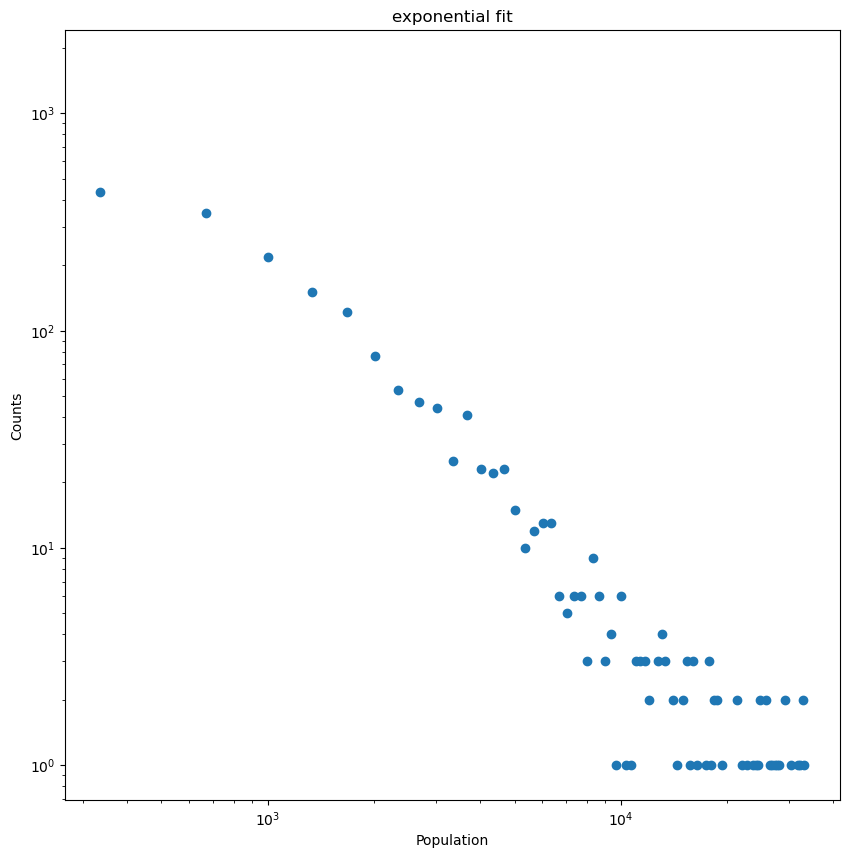

A: 12076917.0
b: 4.71220126468882
Fitting exponential
(array([1.20769170e+07, 4.71220126e+00]), array([[inf, inf],
       [inf, inf]]))
exponential fit:  12076917.0   4.71220126468882
Convergence fit exponential:  True
Optimal parameters:  [1.20769170e+07 4.71220126e+00]
Message:  Optimization terminated successfully.


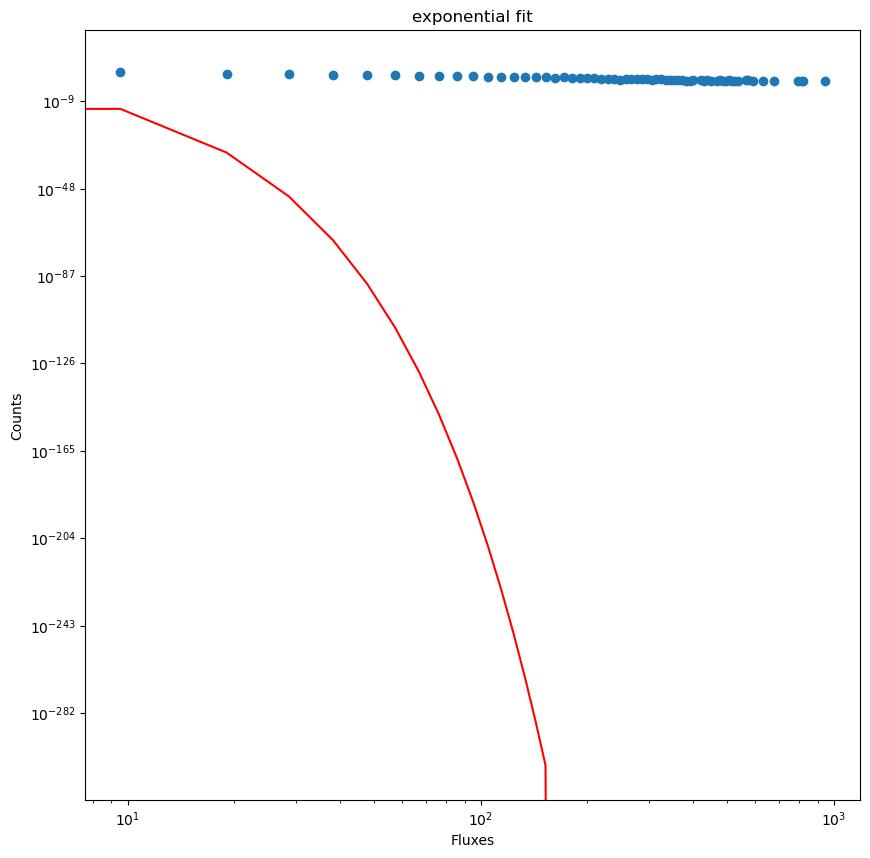

In [ ]:
PlotDistributionFit(grid['population'],'exponential',Name2Function,x_label = 'Population',y_label = 'Counts',x_scale = 'log',y_scale = 'log')
#PlotDistributionFit(grid['population'],'powerlaw',Name2Function,x_label = 'Population',y_label = 'Counts',x_scale = 'log',y_scale = 'log')
PlotDistributionFit(Tij['number_people'],'exponential',Name2Function,x_label = 'Fluxes',y_label = 'Counts',x_scale = 'log',y_scale = 'log')
#PlotDistributionFit(Tij['number_people'],'powerlaw',Name2Function,x_label = 'Fluxes',y_label = 'Counts',x_scale = 'log',y_scale = 'log')
#PlotPotentialLevelCurve(x,y,z,save_dir_local)


# IPF

In [ ]:
np.meshgrid(np.arange(minx, maxx, grid_size), np.arange(miny, maxy, grid_size))


[array([[-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385],
        [-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385],
        [-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385],
        ...,
        [-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385],
        [-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385],
        [-71.728385, -71.708385, -71.688385, ..., -70.568385, -70.548385,
         -70.528385]]),
 array([[41.762821, 41.762821, 41.762821, ..., 41.762821, 41.762821,
         41.762821],
        [41.782821, 41.782821, 41.782821, ..., 41.782821, 41.782821,
         41.782821],
        [41.802821, 41.802821, 41.802821, ..., 41.802821, 41.802821,
         41.802821],
        ...,
        [42.842821, 42.842821, 42.842821, ..., 42.842821, 42.842821,
         42.842821],
        [42.862821, 42.862821, 42.86

cell_x:  762 population:  1329.3068539837586
Invalid:   Tx16: 0  Tx17: 0  mi:  7.3043291166624345  mj:  41.96893821122


/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/PreProcessing/Potential.py:81: RuntimeWarning: invalid value encountered in scalar divide
  # Filter grid DataFrame for populations of cell_i and cell_j
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/PreProcessing/Potential.py:84: RuntimeWarning: invalid value encountered in scalar divide
  if np.isnan(np.log(Txi * mi / (Txj * mj))):


Invalid:   Tx16: 0  Tx18: 0  mi:  7.3043291166624345  mj:  0.5099334170763504
Invalid:   Tx16: 0  Tx31: 0  mi:  7.3043291166624345  mj:  0.25915701707574285
Invalid:   Tx16: 0  Tx32: 0  mi:  7.3043291166624345  mj:  252.8255174119389
Invalid:   Tx16: 0  Tx33: 0  mi:  7.3043291166624345  mj:  528.6843583188297
Invalid:   Tx16: 0  Tx34: 0  mi:  7.3043291166624345  mj:  392.72820322403504
Invalid:   Tx16: 0  Tx35: 0  mi:  7.3043291166624345  mj:  174.2526312119343
Invalid:   Tx16: 0  Tx36: 0  mi:  7.3043291166624345  mj:  455.8088735766474
Invalid:   Tx16: 0  Tx37: 0  mi:  7.3043291166624345  mj:  266.8247996594186
Invalid:   Tx16: 0  Tx38: 0  mi:  7.3043291166624345  mj:  198.69748783934162
Invalid:   Tx16: 0  Tx69: 0  mi:  7.3043291166624345  mj:  4.676775501779572
Invalid:   Tx16: 0  Tx70: 0  mi:  7.3043291166624345  mj:  120.51563069141054
Invalid:   Tx16: 0  Tx71: 0  mi:  7.3043291166624345  mj:  2.4814828851478543
Invalid:   Tx16: 0  Tx72: 0  mi:  7.3043291166624345  mj:  432.829792

KeyboardInterrupt: 

# TRY

In [ ]:
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)


In [ ]:
x_interval = int((maxx - minx) / grid_size)
y_interval = int((maxy - miny) / grid_size)
x = np.arange(bbox[0], bbox[2], grid_size)
y = np.arange(bbox[1], bbox[3], grid_size)
grid_cells = [box(minx + i * grid_size, miny + j * grid_size,
                   minx + (i + 1) * grid_size, miny + (j + 1) * grid_size)
              for i in range(x_interval) for j in range(y_interval)]# Create a GeoDataFrame from the grid cells
grid_points = gpd.GeoDataFrame(geometry=[shp.geometry.box(xi, yi, xi + grid_size, yi + grid_size) for xi in x for yi in y], crs='EPSG:4326')
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells)
print(len(grid_points))
print(len(grid_gdf))

#fig, ax = plt.subplots(1,1, figsize=(20,20))
#grid_gdf.plot(ax=ax)
#SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black')
# Save the grid as a GeoJSON file
#grid_gdf.to_file("grid.geojson", driver='GeoJSON')

method i*: 0.1077280044555664
method xi: 0.10428667068481445
3477
                                               geometry
0     POLYGON ((-71.70839 41.76282, -71.70839 41.782...
1     POLYGON ((-71.70839 41.78282, -71.70839 41.802...
2     POLYGON ((-71.70839 41.80282, -71.70839 41.822...
3     POLYGON ((-71.70839 41.82282, -71.70839 41.842...
4     POLYGON ((-71.70839 41.84282, -71.70839 41.862...
...                                                 ...
3472  POLYGON ((-70.50839 42.80282, -70.50839 42.822...
3473  POLYGON ((-70.50839 42.82282, -70.50839 42.842...
3474  POLYGON ((-70.50839 42.84282, -70.50839 42.862...
3475  POLYGON ((-70.50839 42.86282, -70.50839 42.882...
3476  POLYGON ((-70.50839 42.88282, -70.50839 42.902...

[3477 rows x 1 columns]
3360
                                               geometry
0     POLYGON ((-71.70839 41.76282, -71.70839 41.782...
1     POLYGON ((-71.70839 41.78282, -71.70839 41.802...
2     POLYGON ((-71.70839 41.80282, -71.70839 41.822...
3     PO

In [ ]:
import haversine as hs
from collections import defaultdict
grid_gdf['centroidx'] = grid_gdf.centroid.x
grid_gdf['centroidy'] = grid_gdf.centroid.y
centroids = grid_gdf[['centroidx', 'centroidy']].values
batch_size = 10000
direction_matrix = defaultdict(dict)
distance_matrix = defaultdict(dict)
for i in range(0, len(grid_gdf), batch_size):
    print(i)
    t0 = time.time()
    centroids_batch = centroids[i:i+batch_size]
    direction_vectors_batch = centroids_batch[:, np.newaxis, :] - centroids[np.newaxis, :, :]
    t1 = time.time()
    direction_vectors_norm_batch = np.linalg.norm(direction_vectors_batch, axis=-1)
    direction_vectors_normalized_batch = direction_vectors_batch / np.expand_dims(direction_vectors_norm_batch, axis=-1)
    print('shape direction norm: ',np.shape(direction_vectors_normalized_batch))
    t0 = time.time()
#    direction_matrix = {i+k: {j: direction_vectors_normalized_batch[k, j] for j in range(len(grid_gdf))} for k in range(min(batch_size, len(grid_gdf) - i))}
#    distance_matrix = {i+k: {j: hs.haversine((grid_gdf.iloc[i+k]['centroidy'],grid_gdf.iloc[i+k]['centroidx']),(grid_gdf.iloc[j]['centroidy'],grid_gdf.iloc[j]['centroidx'])) for j in range(len(grid_gdf))} for k in range(min(batch_size, len(grid_gdf) - i))}
    for j in range(len(grid_gdf)):
        for k in range(min(batch_size, len(grid_gdf) - i)):
            direction_matrix[i+k][j] = direction_vectors_normalized_batch[k, j]    
            distance_matrix[i+k][j] = hs.haversine((grid_gdf.iloc[i+k]['centroidy'],grid_gdf.iloc[i+k]['centroidx']),(grid_gdf.iloc[j]['centroidy'],grid_gdf.iloc[j]['centroidx']))
#    if j%10000==0:
#        print('i: {0} j: {1} {2}'.format(i,j,k))
#        print('direction matrix: {0} {1}'.format(i+k,j),direction_matrix[i+k][j])
    t1 = time.time()
    print('method direction:',t1-t0)
# Create a DataFrame from the direction vectors
columns = ['i', 'j', 'dir_vector', 'distance']
rows = []
# Iterate over the direction and distance matrices to construct DataFrame rows
for i, dir_row in direction_matrix.items():
    for j, dir_vector in dir_row.items():
        distance = distance_matrix[i][j]
        rows.append([i, j, dir_vector, distance])
# Create DataFrame
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))

df_direction_distance_matrix = pd.DataFrame(rows, columns=columns)
SaveDirectionDistanceMatrix(dir_geometries,grid_size,df_direction_distance_matrix)    

 
SaveDirectionDistanceMatrix(dir_geometries,grid_size,df_direction_distance_matrix)    


0


/tmp/ipykernel_360804/907035494.py:16: RuntimeWarning: invalid value encountered in divide
  direction_vectors_normalized_batch = direction_vectors_batch / np.expand_dims(direction_vectors_norm_batch, axis=-1)


shape direction norm:  (3360, 3360, 2)
method direction: 2818.367124557495
COMPUTING: /home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/grid/0.02/direction_distance_matrix.csv 
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/grid/0.02/direction_distance_matrix.csv ALREADY COMPUTED


,i,j,dir_vector,distance
0,0,0,"[nan, nan]",0.000000
1,0,1,"[7.105427357599891e-13, -1.0]",2.223902
2,0,2,"[0.0, -1.0]",4.447803
3,0,3,"[2.368475785867191e-13, -1.0]",6.671705
4,0,4,"[0.0, -1.0]",8.895606
...,...,...,...,...
11289595,3359,3355,"[0.0, 1.0]",8.895606
11289596,3359,3356,"[-2.368475785866911e-13, 1.0]",6.671705
11289597,3359,3357,"[0.0, 1.0]",4.447803
11289598,3359,3358,"[-7.105427357602415e-13, 1.0]",2.223902
